In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso # Keep this for comparison/alternative use
import statsmodels.api as sm
import random


In [9]:

np.random.seed(0)

n = 500
p = 10
iters = 10000
lam = 0.1
true_beta = np.zeros(p)  # Assuming true beta is all zeros for hypothesis testing
std_noise = 10


In [10]:

X = np.random.normal(0, 1, size=(n, p))


def create_data(X, true_beta, intercept=0, std_noise=1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size=n)
    y = linear_component + noise + intercept
    return y

# Hàm soft_thresholding vẫn giữ nguyên, chỉ sửa lại tên cho đúng chính tả
def soft_thresholding(rho, lam, z):
    if rho < -lam:
        return (rho + lam) / z
    elif rho > lam:
        return (rho - lam) / z
    else:
        return 0

def fit_lasso_model_corrected(X, y, lam, max_iter=7000, tol=1e-5):
    """
    Fits a Lasso model using Coordinate Descent algorithm with intercept.
    
    Args:
        X (np.ndarray): Design matrix.
        y (np.ndarray): Response vector.
        lam (float): Lasso regularization parameter (lambda).
        max_iter (int): Maximum number of iterations for coordinate descent.
        tol (float): Tolerance for convergence.
        
    Returns:
        tuple: (beta_hat, intercept_hat) - Estimated coefficients and intercept.
    """
    n, p = X.shape
    beta = np.zeros(p)
    intercept = np.mean(y) # Initialize intercept with mean of y, common start point

    for iter_num in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept

        # 1. Update Intercept
        # The optimal intercept is the mean of the current residuals.
        intercept = np.mean(y - X @ beta)

        # 2. Iterate through each coefficient to update it
        # The order of updating `beta_j` can be random or fixed. Fixed is simpler.
        for j in range(p):
            # Calculate the partial residual for beta_j:
            # It's y - (predictions from other betas) - intercept
            # Or, more efficiently, y - (full prediction) + (X[:,j] * beta[j])
            partial_residual_j = y - (X @ beta - X[:, j] * beta[j]) - intercept

            # Compute rho_j (dot product of X_j with partial residual, scaled by n)
            # This is the 'raw' gradient without penalty
            rho_j = np.dot(X[:, j], partial_residual_j) / n

            # Compute z_j (squared L2 norm of X_j, scaled by n)
            # This is the Hessian term
            z_j = np.sum(X[:, j]**2) / n

            # Apply soft-thresholding to update beta[j]
            beta[j] = soft_thresholding(rho_j, lam, z_j)

        # 3. Check for convergence (both beta and intercept)
        if (np.linalg.norm(beta - beta_old, ord=1) < tol and
            abs(intercept - intercept_old) < tol):
            break
            
    # Optional: Set very small coefficients to zero to enforce strict sparsity
    # This aligns with Lasso's behavior where coefficients are either exactly zero or non-zero.
    beta[np.abs(beta) < tol] = 0.0

    return beta, intercept

# --- Các hàm khác (từ mã của bạn) ---

# Hàm soft_thresholding từ mã gốc của bạn (được sửa tên để khớp)
def soft_thresholding(rho, lam, z):
    if rho < -lam:
        return (rho + lam)/z
    elif rho > lam:
        return (rho - lam)/z
    else:
        return 0

# Hàm f (p-value calculation) từ phiên bản sửa đổi trước đó của tôi
def f(mu, sigma, a, b, x):
    if sigma <= 1e-9:
        return np.nan
    
    denom = norm.cdf(b, loc=mu, scale=sigma) - norm.cdf(a, loc=mu, scale=sigma)
    if denom <= 1e-9:
        return np.nan
    
    cdf_at_x = (norm.cdf(x, loc=mu, scale=sigma) - norm.cdf(a, loc=mu, scale=sigma)) / denom
    p_value = 2 * min(cdf_at_x, 1 - cdf_at_x)
    return p_value

# Hàm calculating_p_value (được sửa đổi dựa trên các cuộc thảo luận trước)
def calculating_p_value(X, active_set, y, beta_hat, intercept, std_noise, lam):
    n, p = X.shape
    if len(active_set) == 0:
        return np.nan 
    
    X_active = X[:, active_set]
    beta_hat_active = beta_hat[active_set]
    p_active = len(active_set)
    s = np.sign(beta_hat_active)
    s[s == 0] = 1 

    choice = random.randint(0, p_active - 1)
    e_j = np.zeros(p_active)
    e_j[choice] = 1 
    
    try:
        X_plus = np.linalg.inv(X_active.T @ X_active) @ X_active.T
    except np.linalg.LinAlgError:
        return np.nan
    eta = (X_plus.T @ e_j).reshape(-1, 1)
    
    covariance_matrix = np.diag([std_noise ** 2] * n) 
    identity_n = np.identity(n)
    
    projection_matrix = X_active @ np.linalg.inv(X_active.T @ X_active) @ X_active.T
    
    non_active_set = np.setdiff1d(np.arange(p), active_set)
    
    if len(non_active_set) == 0:
        A_0 = np.empty((0, n))
        b_0 = np.empty((0, 1))
    else:
        X_nonactive = X[:, non_active_set]
        A_0_helper = X_nonactive.T @ (identity_n - projection_matrix)
        b_0_helper_lasso_kkt = (X_nonactive.T @ X_plus.T @ s).reshape(-1, 1)
        A_0 = (1/lam) * np.vstack([A_0_helper, -A_0_helper]) 
        b_0 = np.vstack([1 - b_0_helper_lasso_kkt, 1 + b_0_helper_lasso_kkt])
        
    A_1 = -np.diag(s) @ X_plus
    try:
        b_1 = (- lam * np.diag(s) @ np.linalg.inv(X_active.T @ X_active) @ s).reshape(-1, 1)
    except np.linalg.LinAlgError:
        return np.nan
    
    A = np.vstack([A_0, A_1])
    b = np.vstack([b_0, b_1])

    try:
        c = covariance_matrix @ eta @ np.linalg.inv(eta.T @ covariance_matrix @ eta)
    except np.linalg.LinAlgError:
        return np.nan

    # Correct z calculation from Lemma 5.1 (as discussed previously)
    z = (identity_n - c @ eta.T) @ y # THIS IS THE CORRECTED Z FROM THE PAPER'S NOTATION
    
    Az = A @ z
    Ac = A @ c
    
    vminus = float('-inf')
    vplus = float('inf')
    v_0 = float('inf') 
    
    for idx in range(A.shape[0]):
        if Ac[idx] > 1e-9:
            if (b[idx] - Az[idx]) / Ac[idx] < vplus:
                vplus = (b[idx] - Az[idx]) / Ac[idx]
        elif Ac[idx] < -1e-9:
            if (b[idx] - Az[idx]) / Ac[idx] > vminus:
                vminus = (b[idx] - Az[idx]) / Ac[idx]
        else:
            if (b[idx] - Az[idx]) < v_0:
                v_0 = (b[idx] - Az[idx])

    if v_0 < -1e-9: 
        return np.nan 
    
    mu_cond = 0 
    sigma_cond = np.sqrt(eta.T @ covariance_matrix @ eta)[0,0]

    observed_eta_y = (eta.T @ y)[0]

    p_value = f(mu_cond, sigma_cond, vminus, vplus, observed_eta_y)
    p_value = np.clip(p_value, 0.0, 1.0)
    
    return float(p_value)


In [11]:

# --- Simulation Loop ---
beta_hat_list = [] 
p_values_lists = [] 

for iter_count in range(iters):
    y = create_data(X, true_beta, 0, std_noise)
    
    # Sử dụng hàm Lasso đã sửa của bạn
    beta_hat_custom, intercept_custom = fit_lasso_model_corrected(X, y, lam)
    
    full_beta = np.concatenate([[intercept_custom], beta_hat_custom])
    beta_hat_list.append(full_beta)

    active_set = np.where(np.abs(beta_hat_custom) > 1e-4)[0] # Sử dụng beta_hat_custom
    
    if len(active_set) == 0:
        p_value = np.nan
    else:
        p_value = calculating_p_value(X, active_set, y, beta_hat_custom, intercept_custom, std_noise, lam)
    
    if not np.isnan(p_value):
        p_values_lists.append(p_value)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11392\737930429.py:185: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(p_value)


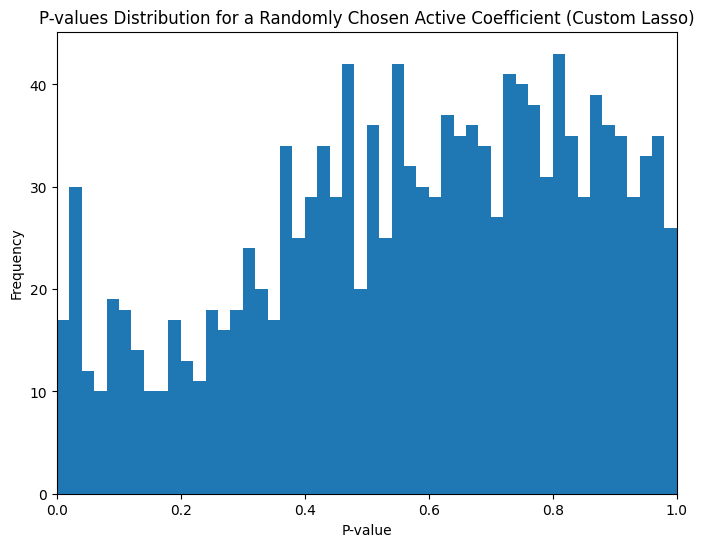

In [12]:

# --- Plotting Results ---
plt.figure(figsize=(8, 6))
plt.xlim(0, 1)

plt.hist(p_values_lists, bins = 50)
plt.title('P-values Distribution for a Randomly Chosen Active Coefficient (Custom Lasso)')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

In [13]:
print(len(p_values_lists))
print(p_values_lists)

1360
[0.37448485149334115, 0.6269091600050343, 0.03697839283196891, 0.7689730413952789, 0.1754482669362856, 0.5907725226498654, 0.7276885242923552, 0.3922326741687402, 0.5660531956732209, 0.5618144687294272, 0.7729004286130203, 0.7717528129582729, 0.8777320866197662, 0.37359038106141274, 0.1437037416676008, 0.6651432626164092, 0.34901944075976066, 0.7508852938057268, 0.3204657393835262, 0.8976168841207772, 0.30046227277757254, 0.9666647989439136, 0.2104173909485353, 0.7029138195407738, 0.21336363816017534, 0.020217546422233834, 0.692357500015587, 0.4728459176773945, 0.18123923002784517, 0.7114688543980637, 0.6453329144246249, 0.16132956014322097, 0.66804473282842, 0.12808834434790506, 0.5588799776674543, 0.5864231844933603, 0.8505502775532527, 0.1339789980203998, 0.728015449730232, 0.8807672061162384, 0.08009522214187564, 0.45599402838651537, 0.30068917008884477, 0.1603045361430197, 0.4387556993449919, 0.8276331671324764, 0.8510117486748552, 0.6663896179009313, 0.40703718631561847, 0.5